<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/3.%20Clasificador%20Multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador Multilabel

https://walkwithfastai.com/Multi_Label

## Librerías

Instalamos la última versión de Fastai:

In [1]:
!pip install fastai -Uq

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 197 kB 5.4 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 


{'restart': True, 'status': 'ok'}

Importamos las librerías necesarias:

In [1]:
from fastai.vision.all import *

In [2]:
import pandas as pd

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models import resnet34

## Dataset

Descargamos el dataset

In [3]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 -O val.zip

--2022-05-20 15:09:34--  https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/o1eaoae59qgdo4i/Training_Set_Pre.zip [following]
--2022-05-20 15:09:35--  https://www.dropbox.com/s/raw/o1eaoae59qgdo4i/Training_Set_Pre.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1a042140e097dd33c1448f39e2.dl.dropboxusercontent.com/cd/0/inline/Blpn-77w7RNjCPcIJLDZOkywl55eSgi_8y8siKiS-f8-xL6SDqhzt_nGLEYkH__f7uNYSFI44X5FfQCjjkIDMWk3z5Q3ewDI9Zgg2YC4LZqzXXbPTDFEhKanh2BOtEjCI0J3OHpEfekSp1wN_fWcSGoEFQam64koSqDv1KW1fjwJWQ/file# [following]
--2022-05-20 15:09:35--  https://uc1a042140e097dd33c1448f39e2.dl.dropboxusercontent.com/cd/0/inline/Blpn-77w7RNjCPcIJLDZOkywl55eSgi_8y8siKi

In [4]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [5]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [74]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [75]:
df_train

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Para este problema de clasificación solo tendremos en cuenta las imágenes con riesgo de enfermedad (Disease_Risk) de 1.

In [76]:
df_train['Disease_Risk'].value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

In [77]:
df_train = df_train.loc[df_train['Disease_Risk'] == 1]

In [78]:
#La columna Disease_Risk ya no nos hace falta, podríamos eliminarla, vemos que hay 28 clases
# df_train.iloc[:, 1:]
df_train = df_train.reset_index(drop=True) #Elimino la columna index con drop=True
df_train

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,1910,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1515,1914,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1516,1915,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1517,1916,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
columnas = list(df_train.columns)[2:]

nombres = []
enfermedades = []

for i in df_train.index:
  cadena = ''
  nombres.append(df_train['ID'][i])
  for x in columnas:
    if(df_train[x][i]==1):
      cadena += cadena + ' ' + x
  enfermedades.append(cadena)

In [147]:
data = {'nombre_img': nombres,
        'tags': enfermedades
        }
df = pd.DataFrame(data)

In [152]:
df.head(5)

,nombre_img,tags
0,1,DR
1,2,DR
2,3,DR
3,4,MH MH ODC
4,5,DR DR LS


## Datablock

In [153]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [159]:
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=trainPath/'Training', suff='.png'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms = batch_tfms)

In [160]:
dls = db.dataloaders(df)

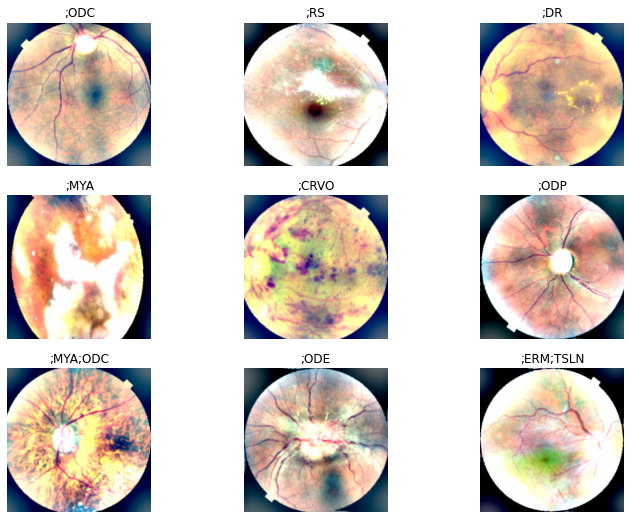

In [161]:
dls.show_batch(max_n=9, figsize=(12,9))

## Entrenar Modelo

In [162]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.002511886414140463)

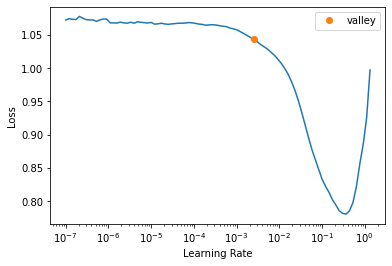

In [163]:
learn.lr_find()

In [165]:
learn = learn.to_fp16()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.945479,0.861193,0.562877,00:16
